In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

### Define the model inputs:

In [3]:
# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude'),
    'median_income':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='median_income'),
    'population':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='population')
}

### Create preprocessing layers outputting three features:

- `median_income`
- `population`
- `latitude` X `longitude` (a feature cross)

In [5]:
# Create a Normalization layer to normalize the median_income data.
median_income = tf.keras.layers.Normalization(
    name='normalization_median_income',
    axis=None)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# Create a Normalization layer to normalize the population data.
population = tf.keras.layers.Normalization(
    name='normalization_population',
    axis=None)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# Create a list of numbers representing the bucket boundaries for latitude.
# Because we're using a Normalization layer, values for latitude and longitude
# will be in the range of approximately -3 to 3 (representing the Z score).
# We'll create 20 buckets, which requires 21 bucket boundaries (hence, 20+1).
latitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the latitude data.
latitude = tf.keras.layers.Normalization(
    name='normalization_latitude',
    axis=None)
latitude.adapt(train_df['latitude'])
latitude = latitude(inputs.get('latitude'))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the longitude data.
longitude = tf.keras.layers.Normalization(
    name='normalization_longitude',
    axis=None)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(longitude)

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    # num_bins can be adjusted: Higher values improve accuracy, lower values
    # improve performance.
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# Concatenate our inputs into a single tensor.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population])

### Build a linear regression model as a baseline

In [7]:
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_median_house_value_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

### Define normalized label columns

In [8]:
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))

### Define a linear regression model outputs

In [9]:
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

### Train and Evaluate Linear Regression Baseline Model

Epoch 1/15
14/14 [==============================] - 1s 18ms/step - loss: 0.7211 - mean_squared_error: 0.7211 - val_loss: 0.6192 - val_mean_squared_error: 0.6192
Epoch 2/15
14/14 [==============================] - 0s 5ms/step - loss: 0.5220 - mean_squared_error: 0.5220 - val_loss: 0.4717 - val_mean_squared_error: 0.4717
Epoch 3/15
14/14 [==============================] - 0s 5ms/step - loss: 0.4131 - mean_squared_error: 0.4131 - val_loss: 0.3994 - val_mean_squared_error: 0.3994
Epoch 4/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3647 - mean_squared_error: 0.3647 - val_loss: 0.3717 - val_mean_squared_error: 0.3717
Epoch 5/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3477 - mean_squared_error: 0.3477 - val_loss: 0.3619 - val_mean_squared_error: 0.3619
Epoch 6/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3417 - mean_squared_error: 0.3417 - val_loss: 0.3576 - val_mean_squared_error: 0.3576
Epoch 7/15
14/14 [=====================

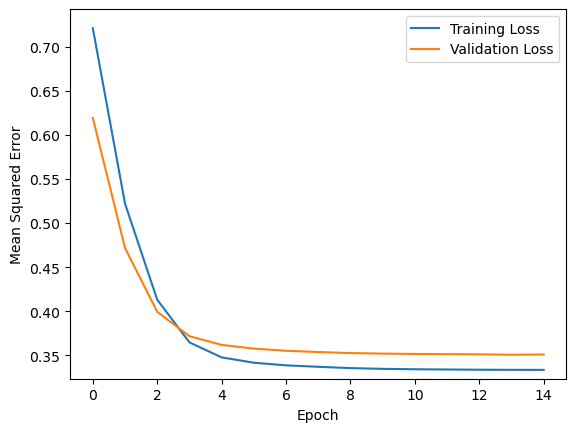


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 0s/step - loss: 0.3604 - mean_squared_error: 0.3604


{'loss': 0.3604382276535034, 'mean_squared_error': 0.3604382276535034}

In [13]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

### Define a deep neural net model

The `get_outputs_dnn()` function defines the topography of the Deep Neural Net (dnn), specifying:
- The number of layers in the dnn
- The number of nodes in each layer
- The acivation function of each layer

Note that the first Dense layer takes the preprocessing layers as input.

In [11]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

### Define hyperparameters and the label

In [25]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

### Call functions to build the model

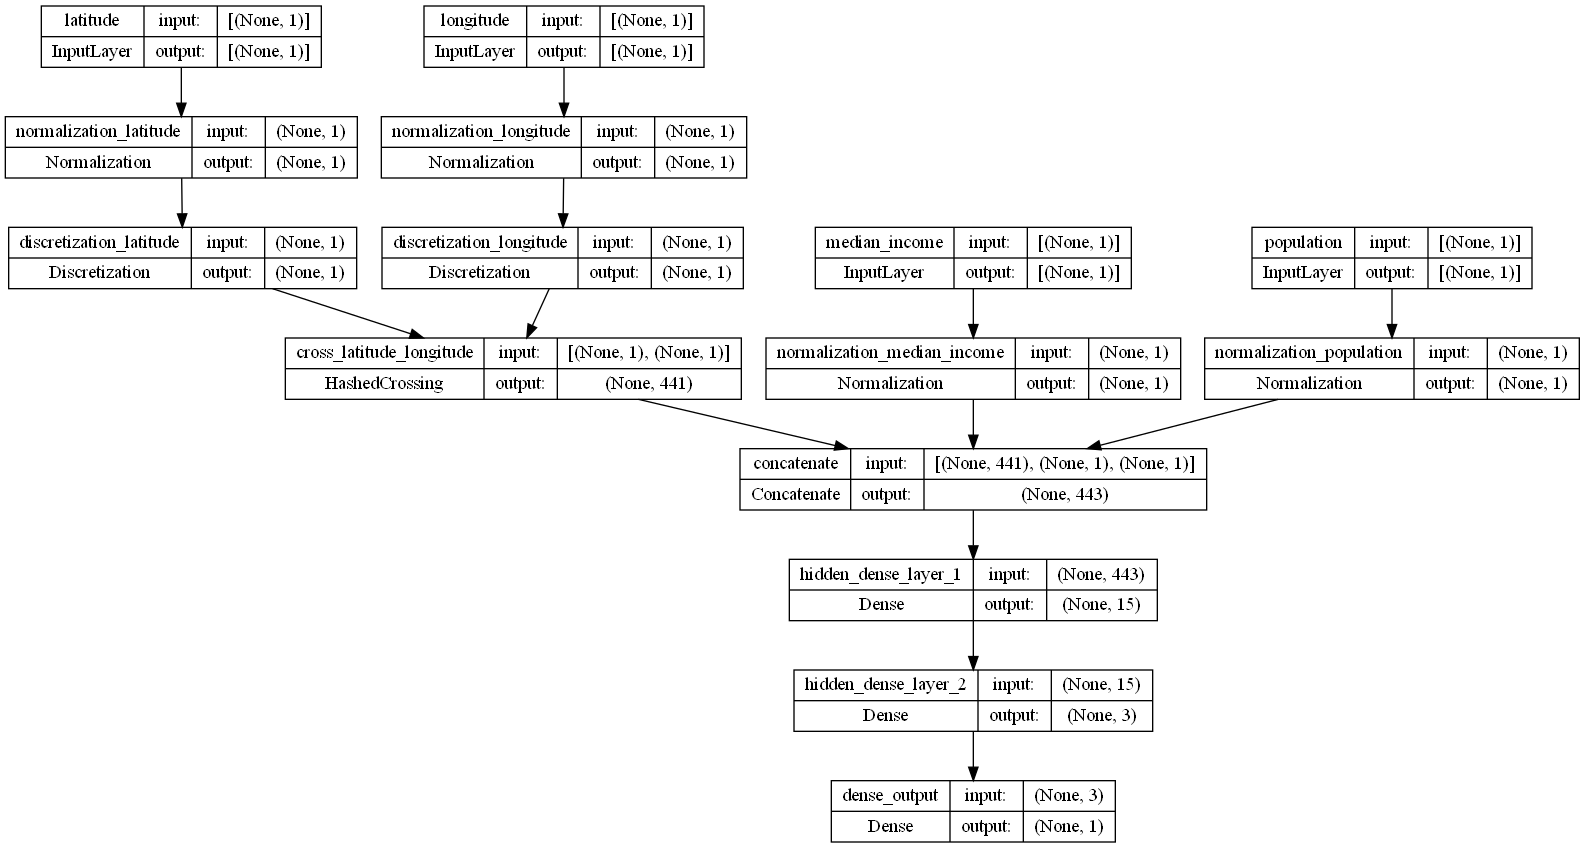

In [27]:
dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Visualize the model's topography.
tf.keras.utils.plot_model(my_model, show_shapes=True)

### Call functions to train and test the DNN

Epoch 1/20


c:\Users\AMD\Anaconda3\envs\FelipeAlbuquerque\lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 1s 21ms/step - loss: 0.7561 - mean_squared_error: 0.7561 - val_loss: 0.4789 - val_mean_squared_error: 0.4789
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3907 - mean_squared_error: 0.3907 - val_loss: 0.3741 - val_mean_squared_error: 0.3741
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3417 - mean_squared_error: 0.3417 - val_loss: 0.3513 - val_mean_squared_error: 0.3513
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.3302 - mean_squared_error: 0.3302 - val_loss: 0.3405 - val_mean_squared_error: 0.3405
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3245 - mean_squared_error: 0.3245 - val_loss: 0.3379 - val_mean_squared_error: 0.3379
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3220 - mean_squared_error: 0.3220 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 7/20
14/14 [==============================] 

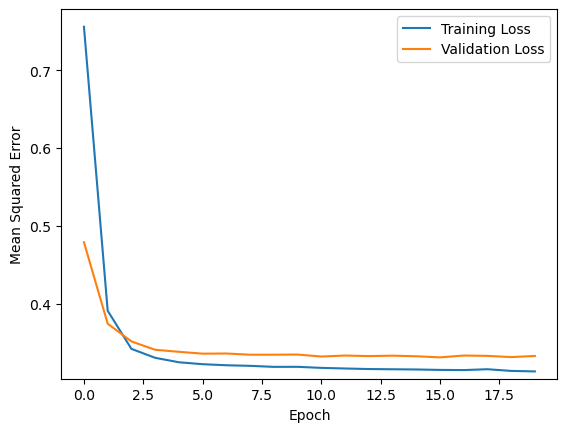


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 6ms/step - loss: 0.3483 - mean_squared_error: 0.3483


{'loss': 0.34832876920700073, 'mean_squared_error': 0.34832876920700073}

In [28]:
# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

### Compare the baseline linear regression model with the neural net

$ MSE_{linReg} = 0.36 $ versus $ MSE_{dnn} = 0.34 $

$ \frac{0.36 - 0.34}{0.36} * 100 = 5.5 $%

### Optimize the Deep Neural Network's topography

Goals:

- Lower the loss against the test set
- Minimize the overall number of nodes

Note that the two goals may be in conflict